In [1]:
# # Bizdan Aviachipta narxlarini bashorat qilish so'ralgani uchun Regression algoritmlaridan foydalanamiz

# Avval datasetimizni o'rganib chiqamiz

In [9]:
# kerakli kutubxonalar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [2]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")
sample_df = pd.read_csv("sample_solution.csv")

In [5]:
train_df.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [6]:
# Ushbu maʼlumotlar toʻplami quyidagilarni o'z ichiga oladi:
# Tarkib:
# ID: Ketma - ketlik uchun qo'yilgan sonlar.
# Airline: Parvoz qilingan aviakompaniya nomi.
# Flight: Parvoz qilingan ID raqami.
# Source_city: Parvoz qaysi shahardan boshlanishi.
# Departure_time: Samolyotning ketish vaqti.
# Stop: Parvoz davomida to'xtashlar soni.
# Arrival_time: Qaytish vaqti.
# Destination_city: Qaysi davlatga parvoz qilinayotgani.
# Class: Foydalanuvchi samolyotning qaysi klass turidan foydalanib uchganligi.
# Duration: Parvoz davomiyligi.
# Days_left: Samolyotning qancha vaqtdan keyin qaytishi.

In [7]:
# nan qiymatlar bor yo'qligini tekshiramiz
train_df.isnull().sum()

id                  0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

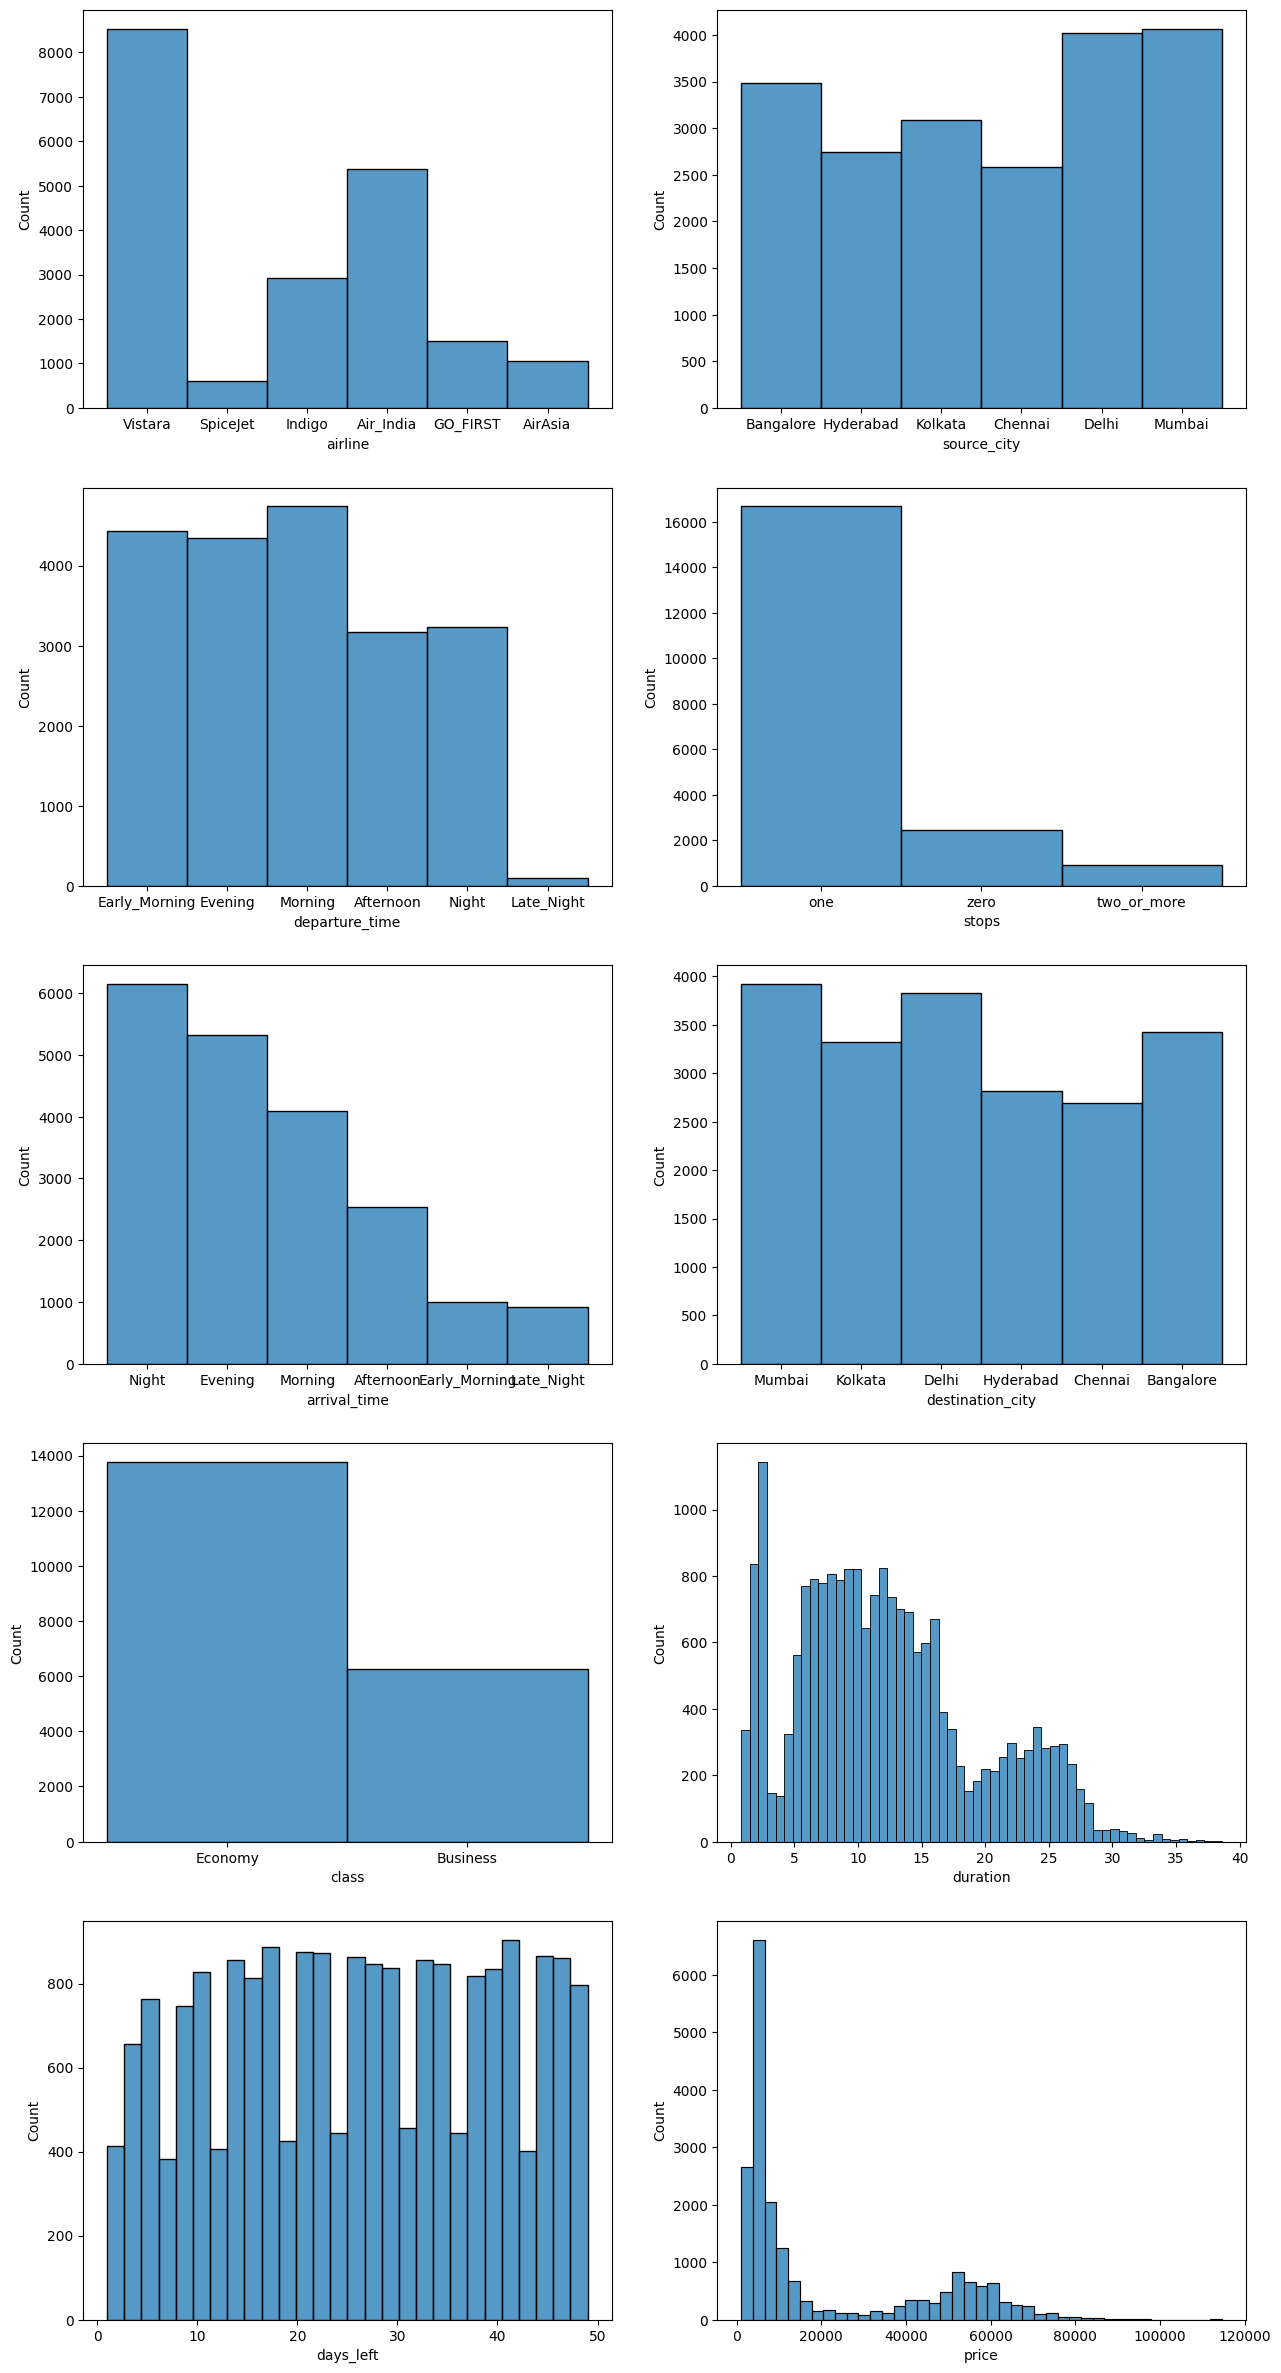

In [11]:
# ma'lumotlarni grafik holatda chiqaramiz
fig, axes = plt.subplots(5,2, figsize=(15,30))
sns.histplot(data=train_df, x='airline',ax=axes[0,0])
sns.histplot(data=train_df, x='source_city',ax=axes[0,1])
sns.histplot(data=train_df, x='departure_time',ax=axes[1,0])
sns.histplot(data=train_df, x='stops',ax=axes[1,1])
sns.histplot(data=train_df, x='arrival_time',ax=axes[2,0])
sns.histplot(data=train_df, x='destination_city',ax=axes[2,1])
sns.histplot(data=train_df, x='class',ax=axes[3,0])
sns.histplot(data=train_df, x='duration',ax=axes[3,1])
sns.histplot(data=train_df, x='days_left',ax=axes[4,0])
sns.histplot(data=train_df, x='price',ax=axes[4,1])
plt.show()

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


In [25]:
# ma'lumotlarga ishlov berish uchun funksiya yozib olamiz
def data_preparation(data, test=False):
    if test:
        X = data.drop("id",axis=1)
        # ma'lumotlarimizda flight ustunidagi qiymatlar takrorlanmagani uchun ularni raqamlarga aylabtirib 
        # bo'lmaydi. ammo ularni boshidagi ikkita harflari takrorlangani uchun ularni harflar va raqamlarga
        # ajratib olamiz
        flight = X['flight'].str.split("-",expand=True)
        X["flight_str"] = flight[0]
        X["flight_num"] = flight[1].astype('float64')
        X.drop("flight",axis=1, inplace=True)
        # matnlarni raqamlarga aylantirib olamiz
        X = pd.get_dummies(X)
        return X
    else:
        X = data.drop(["id",'price'],axis=1)
        Y = data['price'].copy()
        flight = X['flight'].str.split("-",expand=True)
        X["flight_str"] = flight[0]
        X["flight_num"] = flight[1].astype(np.float64)
        X.drop("flight",axis=1, inplace=True)
        X = pd.get_dummies(X)
        return [X, Y]


In [27]:
datas = data_preparation(train_df)
datas[0]

,duration,days_left,flight_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy,flight_str_6E,flight_str_AI,flight_str_G8,flight_str_I5,flight_str_SG,flight_str_UK
0,14.25,21,810.0,False,False,False,False,False,True,True,...,False,True,False,True,False,False,False,False,False,True
1,1.75,7,5094.0,False,False,False,False,True,False,False,...,True,False,False,True,False,False,False,False,True,False
2,9.58,5,846.0,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,False,True
3,6.75,28,706.0,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
4,2.00,4,5394.0,False,False,False,True,False,False,False,...,False,True,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7.92,45,6178.0,False,False,False,True,False,False,True,...,False,True,False,True,True,False,False,False,False,False
19996,5.83,24,582.0,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
19997,35.33,17,832.0,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
19998,16.33,21,996.0,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True


In [18]:
datas[1]

0         7212
1         5292
2        60553
3         5760
4        10712
         ...  
19995     3153
19996     3911
19997    14822
19998     6450
19999     7141
Name: price, Length: 20000, dtype: int64

In [19]:
# ma'lumotlarni train va test setlar uchun ajratib olamiz
x_train, x_test, y_train, y_test = train_test_split(datas[0], datas[1], test_size=0.2, random_state=42)

In [21]:
# modelimizni train qilamiz
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
tree_model = DecisionTreeRegressor()

lr_model.fit(x_train, y_train)
rf_model.fit(x_train, y_train)
tree_model.fit(x_train, y_train)

lr_pred = lr_model.predict(x_test)
rf_pred = rf_model.predict(x_test)
tree_pred = tree_model.predict(x_test)

In [22]:
print (f"LinearRegression aniqligi: {mean_absolute_error(y_test, lr_pred)}")
print (f"RandomForest aniqligi: {mean_absolute_error(y_test, rf_pred)}")
print (f"DecisionTree aniqligi: {mean_absolute_error(y_test, tree_pred)}")

LinearRegression aniqligi: 4547.6531299646695
RandomForest aniqligi: 1611.7069220416668
DecisionTree aniqligi: 1832.242375


In [23]:
# Bizda eng aniqligi yuqori model RandomForest modeli ekan. Biz ma'lumotlarimizni bashorat qilishda
# shu modeldan foydalanamiz

In [30]:
test_data = data_preparation(test_df, test=True)
test_data

,duration,days_left,flight_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy,flight_str_6E,flight_str_AI,flight_str_G8,flight_str_I5,flight_str_SG,flight_str_UK
0,28.25,2,765.0,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,13.83,34,747.0,False,False,False,False,False,True,False,...,False,True,True,False,False,False,False,False,False,True
2,2.00,30,570.0,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
3,5.17,26,974.0,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,16.33,35,770.0,False,True,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,17.42,15,768.0,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
4996,3.00,40,6214.0,False,False,False,True,False,False,False,...,False,True,False,True,True,False,False,False,False,False
4997,11.17,37,402.0,False,True,False,False,False,False,False,...,False,True,True,False,False,True,False,False,False,False
4998,13.33,38,673.0,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False


In [31]:
# Random Forest Regressor dan foydalanib datamizni bashorat qilamiz
test_pred = rf_model.predict(test_data)
test_pred

array([52580.01, 64710.09, 23490.26, ..., 50462.66, 49470.75, 66855.91])

In [34]:
# tayyor bo'lgan ma'lumotlarimizni sample_df ga yuklaymiz
sample_df.head()

,id,price
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [35]:
sample_df['price'] = test_pred
sample_df.head()

,id,price
0,1,52580.01
1,2,64710.09
2,3,23490.26
3,4,2963.94
4,5,5876.18


In [38]:
# ma'lumotlarimizni saqlab olamiz
sample_df.to_csv('sample_solution_pred.csv', index=False)

In [39]:
# saqlagan ma'lumotimizni tekshirib olamiz
df = pd.read_csv("sample_solution_pred.csv")
df.head()

,id,price
0,1,52580.01
1,2,64710.09
2,3,23490.26
3,4,2963.94
4,5,5876.18
